In [1]:
from itertools import chain
from utils import *
from IPython.core.interactiveshell import InteractiveShell

import keras
import tensorflow as tf
import sklearn 
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session

In [2]:
#pd.set_option('display.max_colwidth', None)
InteractiveShell.ast_node_interactivity = "all"

In [3]:
dados1 = pd.read_excel('Prontuarios.xlsx')
dados2 = pd.read_excel('Perfil.xlsx')

In [4]:
df1 = pd.merge(dados1, dados2, on="NR_REGISTRO")

In [5]:
df1.head()

,Unnamed: 0,NR_REGISTRO,TEXTO,Unidade,DT_ADMISSAO,SEXO,DT_NASCIMENTO,EST_RESID,TABAGISMO,ALCOOL_CD
0,0.0,D092074,"_x000D_\nPaciente do sexo feminino, 49 anos de...",BSB,2000-03-09,F,1947-01-09,DF,SIM,NÃO
1,0.0,D101411,"_x000D_\nInformante: Cláudia, a mãe._x000D_\n_...",BSB,2001-01-02,M,1995-06-17,DF,NÃO,NÃO
2,0.0,D101423,"IDENTIFICAÇÃO: Paciente de 44 anos, feminina, ...",BSB,2001-01-02,F,1956-05-31,GO,SIM,NÃO
3,0.0,D101486,"Paciente de 91 anos, feminina, branca, viúva, ...",BSB,2001-01-05,F,1909-01-29,DF,NÃO,NÃO
4,0.0,D101487,"IDENTIFICAÇÃO: paciente com 46 anos, feminina,...",BSB,2001-01-05,F,1954-10-20,DF,NÃO,NÃO


In [6]:
df1.drop(['Unnamed: 0'], axis = 1, inplace = True)
df1["TABAGISMO"] = np.where(df1["TABAGISMO"] == "SIM", 1, 0)
df1["ALCOOL_CD"] = np.where(df1["ALCOOL_CD"] == "SIM", 1, 0)
df1["SEXO"] = np.where(df1["SEXO"] == "F", 1, 0) # MULHER:1 HOMEM:0

In [7]:
#df1.head()
df1.shape

(28087, 9)

In [8]:
# df1["index"] = range(4369)
# df1 = df1.set_index("index")

In [9]:
df1.DT_ADMISSAO = pd.Series(map(lambda x: x.year, df1.DT_ADMISSAO))
df1.DT_NASCIMENTO = pd.Series(map(lambda x: x.year, df1.DT_NASCIMENTO))

In [10]:
df = df1.copy()

# Tratando o dataset

In [11]:
palavras_uteis = ["cigarro","cigarros","fumante","tabagismo","tabagista","fumou","fuma","fumava",'tabaco','maco',"fumando","tabagica"]#ictus

In [12]:
#prepare the words, removing stop words, not characters
df.TEXTO = pd.Series(map(lambda x: arrange_plus(x, 10, 10, "1",palavras_uteis), df.TEXTO)) 



In [13]:
#df = df.sample(frac=1).reset_index(drop=True)
df = df[df.TEXTO != 'vazio']
df["index"] = range(24838)
df = df.set_index("index")


In [14]:
x = df.iloc[:, 1]
y = df['TABAGISMO']


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
sentences_train, sentences_test, y_train, y_test = train_test_split(x, y, test_size=.15, random_state= 10)


In [17]:
vocab_size, x_train, x_test, maxlen = pre_process(sentences_train, sentences_test, 2000, 100)


# Modelos

###  Modelo CNN 

In [18]:
parada = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
    
)

In [19]:
def build_model(embedding_dim,dropout,lr,ls):   

    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen)) 
    model.add(layers.Conv1D(64, 7, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=ls),
                  metrics=['accuracy'])
    return model

In [20]:
def build_model1(embedding_dim, num_filters, kernel_size, dropout,lr,ls):   

    model = Sequential()
    model.add(layers.Embedding(2000, embedding_dim, input_length=100)) 
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=ls),
                  metrics=['accuracy'])
    return model

### Tunando os parâmetros com RandomSearch

In [21]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV


# #embedding_dim = 50
# maxlen = 100


# # Train-test split
# sentences_train_H, sentences_test_H, y_train_H, y_test_H = train_test_split(
#     x, y, test_size=0.2, random_state=10)

# # Tokenize words
# tokenizer = Tokenizer(num_words=1000)
# tokenizer.fit_on_texts(sentences_train)
# X_train_H = tokenizer.texts_to_sequences(sentences_train)
# X_test_H = tokenizer.texts_to_sequences(sentences_test)

# # Adding 1 because of reserved 0 index
# vocab_size = len(tokenizer.word_index) + 1

# # Pad sequences with zeros
# X_train_H = pad_sequences(X_train_H, padding='post', maxlen=maxlen)
# X_test_H = pad_sequences(X_test_H, padding='post', maxlen=maxlen)

# # Parameter grid for grid search
# param_grid = dict(num_filters=[32, 64, 128],
#                   kernel_size=[3, 5, 7],
#                   embedding_dim=[30,40,50,60,80,100],
#                   dropout = [0.2,0.3,0.4,0.5],
#                   lr = [0.0001,0.0003],
#                   ls = [0,0.1,0.2])

# model = KerasClassifier(build_fn=build_model1,verbose=False,batch_size  = 32,epochs = 20)

    
# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                              cv=6, verbose=1, n_iter=6, n_jobs = -1)
# grid_result = grid.fit(X_train_H, y_train_H)


# # Evaluate testing set
# test_accuracy = grid.score(X_test_H, y_test_H)

# s = ('Best Accuracy : '
#     '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')

# output_string = s.format(
#     grid_result.best_score_,
#     grid_result.best_params_,
#     test_accuracy)
# print(output_string)
      

In [53]:
clear_session()

In [54]:
model2 = build_model1(embedding_dim = 130, num_filters =150, kernel_size = 7, dropout = 0.2, lr = 0.0001, ls = 0.1)

In [24]:
#model2.summary()

Epoch 1/100
70/70 - 9s - loss: 0.6124 - accuracy: 0.7332 - val_loss: 0.5550 - val_accuracy: 0.7386
Epoch 2/100
70/70 - 10s - loss: 0.5297 - accuracy: 0.7458 - val_loss: 0.4884 - val_accuracy: 0.7982
Epoch 3/100
70/70 - 9s - loss: 0.4731 - accuracy: 0.8064 - val_loss: 0.4458 - val_accuracy: 0.8295
Epoch 4/100
70/70 - 10s - loss: 0.4441 - accuracy: 0.8334 - val_loss: 0.4270 - val_accuracy: 0.8510
Epoch 5/100
70/70 - 10s - loss: 0.4286 - accuracy: 0.8481 - val_loss: 0.4187 - val_accuracy: 0.8544
Epoch 6/100
70/70 - 9s - loss: 0.4211 - accuracy: 0.8528 - val_loss: 0.4136 - val_accuracy: 0.8576
Epoch 7/100
70/70 - 9s - loss: 0.4160 - accuracy: 0.8601 - val_loss: 0.4099 - val_accuracy: 0.8595
Epoch 8/100
70/70 - 9s - loss: 0.4094 - accuracy: 0.8625 - val_loss: 0.4061 - val_accuracy: 0.8626
Epoch 9/100
70/70 - 10s - loss: 0.4047 - accuracy: 0.8671 - val_loss: 0.4029 - val_accuracy: 0.8655
Epoch 10/100
70/70 - 10s - loss: 0.4002 - accuracy: 0.8682 - val_loss: 0.4002 - val_accuracy: 0.8655
Epoc

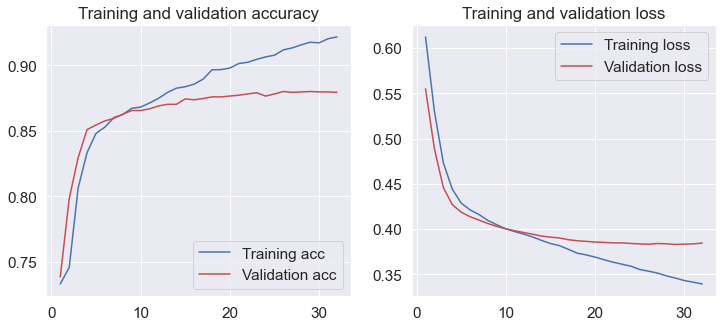

In [55]:

history = model2.fit(x_train, y_train,
                    epochs=100,
                    verbose=2,
                    validation_split = 0.15,
                    batch_size=258,
                    callbacks = parada)

plot_history(history)

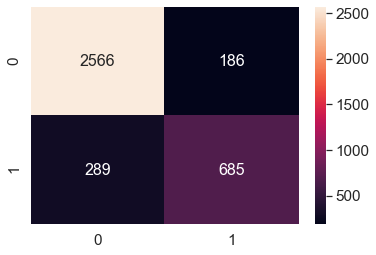

Test loss: 0.3981
Test accuracy: 0.8725


In [56]:
y_pred, predictions = previsao(x_test,y_test,model2)

In [57]:
model2.save('modelo_fumo')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelo_fumo\assets


In [28]:
#keras.utils.plot_model(model2, "my_first_model_with_shape_info.png", show_shapes=True)

In [29]:

# text_input = keras.Input(
#     shape=(100), name = 'text' ) 

# cov_input = keras.Input(shape=(3), name = 'cov' )  
 
    
# text_layer1 = layers.Embedding(2000, 100)(text_input)
# text_layer2 = layers.Conv1D(128, 7, activation='relu')(text_layer1)
# text_layer3 = layers.GlobalMaxPooling1D()(text_layer2)
# text_layer4 = layers.Dense(10, activation="relu")(text_layer3)
# text_layer5 = layers.Dropout(0.2)(text_layer4)


# # Merge all available features into a single large vector via concatenation
# x = layers.concatenate([text_layer5, cov_input])


# output_layer = layers.Dense(1,activation = 'sigmoid')(x)

# # Instantiate an end-to-end model predicting both priority and department
# model = keras.Model(
#     inputs  = [text_input,cov_input],
#     outputs = [output_layer],
# )

In [30]:
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     loss= tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
#     metrics=['accuracy']
        
# )

In [31]:
# model.fit(
#     {"text": x_train, "body": body_data, "tags": tags_data},
#     y_train
#     epochs=2,
#     batch_size=32,
# )

modelo bom:
  -  range(10,10) ou (5,5)
  -  emb_dim = 40
  - maxlen = 60 ou 40
  -  conv1d (64, 7)
  -  dropout = 0.15
  -  lr = 0.0001
  -  epochs = 100
  -  earlystop  = 3
  -  label_smooth = 0.1

In [32]:
(495+2588+676)/(2588+200+255+495+676)


0.8920265780730897

In [33]:
df_test = pd.DataFrame(df.iloc[list(sentences_test.index), :])
df_test["Previsão"] = y_pred
df_test["probabilidade"] = predictions.round(3)


In [34]:
[print(x) for x in df1.TEXTO[df1.NR_REGISTRO == "D197338"] if x != None]

AMBULATÓRIO DE REABILITAÇÃO NEUROLÓGICA / ADMISSÃO_x000D_
_x000D_
IDENTIFICAÇÃO:_x000D_
O Sr. Antônio está com 55 anos de idade, possui Ensino Médio completo, destro, servidor público federal da administração dos jornais do Senado e da Câmara dos Deputados._x000D_
Ele vem acompanhado de sua esposa, Srª. Maria de Fátima, e da filha Moema e do secretário, Sr. Davi._x000D_
Natural de São José da Coroa Grande-PE e residente no Núcleo Bandeirante-DF._x000D_
_x000D_
QUEIXA PRINCIPAL:_x000D_
Acidente vascular cerebral._x000D_
_x000D_
HISTÓRIA DA MOLÉSTIA ATUAL:_x000D_
No dia 12 de outubro de 2010, pela manhã, o paciente apresentou queda súbita ao solo, sem perceber que se encontrava hemiplégico à esquerda. Ao tentar levantar-se, observou presença da paralisia e começou a apresentar dificuldade para comunicar-se com disartria e confusão mental._x000D_
Ele foi atendido pelo SAMU, que o encaminhou para o hospital da localidade. Neste caso, na cidade do interior do Acre. Ele foi medicado e avalia

[None]

In [35]:
#checando
erros = df_test.loc[[x != y for x,y in zip(df_test.TABAGISMO, df_test["Previsão"])], :]
erros.drop(['Unidade','DT_ADMISSAO','SEXO','DT_NASCIMENTO','EST_RESID','ALCOOL_CD'],axis = 1, inplace = True)
erros[(erros.probabilidade > 0.4)&(erros.probabilidade < 0.6)].sort_values(by = 'probabilidade',ascending = False)

C:\Users\601546\.conda\envs\tensorflow_env\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,NR_REGISTRO,TEXTO,TABAGISMO,Previsão,probabilidade
index,,,,,
2790,D179086,historia patologica pregressa ex tabagista par...,0,1,0.599
10971,F007133,ex tabagista carteiras por dia iniciado aos an...,0,1,0.598
17545,N106811,anos tendo descontinuado vicio na ocasiao do i...,0,1,0.596
2542,D170701,refere tabagismo dos aos anos de idade um maco...,0,1,0.593
11413,F009240,em casa propria comodos pessoas com instalacoe...,0,1,0.591
...,...,...,...,...,...
16574,G024885,ele fumava cerca de cigarros dia bebia nos fin...,1,0,0.411
7917,H109775,foi tabagista de ate macos de cigarro por dia ...,1,0,0.408
22890,S086887,porem nao fazia tratamento regular tambem rela...,1,0,0.404
